# Working With The CIFAR10 Dataset

This is it. You've seen how to define a simple convolutional neural network, compute loss w.r.t. the graph Variables, and make gradient updates manually and with `torch.nn.optim` package.
Now you might be thinking:

### What about the data?

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.

- For images, packages such as `Pillow`, `OpenCV` are useful.
- For audio, packages such as `scipy` and `librosa`.
- For text, either raw Python or Cython based loading, or `NLTK` and `SpaCy` are useful.

Specifically for [Computer vision](), the creators of pytorch have generously created a package called `torchvision`, that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`. This provides a huge convinence from writing boiler plate code.

We will use the **CIFAR10 dataset**. It has the classes: *‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’*. The images in CIFAR-10 are of size `3x32x32`, i.e. 3-channel color images of `32x32` pixels in size.

![CIFAR10 Dataset](../images/cifar10.png)

### Training an image classifier

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using `torchvision`.
2. Define a Convolution Neural Network.
3. Define a loss function.
4. Train the network on the training data.
5. Test the network on the test data.

#### 1. Loading and normalizing CIFAR10
Using `torchvision`, it’s extremely easy to load CIFAR10.

In [1]:
%matplotlib inline

# file manipulation
import os.path

# arrays and visualization
import numpy as np
import matplotlib.pyplot as plt

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# Special package provided by pytorch
import torchvision
import torchvision.transforms as transforms

Let's define some *Hyperparameters* we're gonna need later on.

In [2]:
## Hyperparameters.


# image channel 3=RGB, 1=Grayscale
img_channels = 3

# Class labels.
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

# Data directory.
data_dir = '../datasets'  # Dataset directory.
download = True           # Download dataset iff not already downloaded.
normalize = True          # Maybe normalize training data.

# Training parameters
batch_size = 16  # Mini-batch size.
lr = 1e-2        # Optimizer's learning rate.
epochs = 5       # Number of full passes over entire dataset.

The output of the `torchvision` dataset are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

Define the data directory, i.e. where the data should be downloaded to. With the use of `os.path` module.

**NOTE:** `data_dir` could be modified to fit your use.

In [3]:
# Should normalize images or not.
# Normalization helps convergence.
if normalize:
    # Transform rule: Convert to Tensor, Normalize images in range -1 to 1.
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), 
                                                         (0.5, 0.5, 0.5))])
else:
    # Transform rule: Convert to Tensor without normalizing image
    transform = transforms.Compose([transforms.ToTensor()])

# Download the training set and apply the transform rule to each.
trainset = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=download, transform=transform)
# Load the training set into mini-batches and shuffle them
trainset = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Download the testing set and apply the transform rule to each.
testset = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=download, transform=transform)
# Load the testing set into mini-batches and shuffle them as well.
testset = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


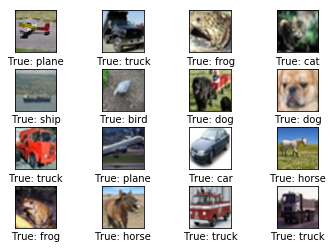

In [4]:
# Helper function to plot images and labels
def imshow(images, labels, pred=None, smooth=True):
    images = images / 2 + 0.5 if normalize else images
    # Create figure with sub-plots.
    fig, axes = plt.subplots(4, 4)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    wspace, hspace = 0.2, 0.8 if pred is not None else 0.4
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        smooth = 'spline16' if smooth else 'nearest'

        # Plot image.
        ax.imshow(np.transpose(images[i], (1, 2, 0)), interpolation=smooth)
            
        # Name of the true class.
        labels_name = classes[labels[i]]

        # Show true and predicted classes.
        if pred is None:
            xlabel = f'True: {labels_name}'
        else:
            # Name of the predicted class.
            pred_name = classes[pred[i]]
            
            xlabel = f'True: {labels_name}\nPred: {pred_name}'

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


# Visualization function to visualize dataset.
def visualize(data, smooth=False):
    # Iterate over the data.
    data_iter = iter(data)
    
    # Unpack images and labels.
    images, labels = data_iter.next()
    
    # Free up memory
    del data_iter
    
    # Call to helper function for plotting images.
    imshow(images, labels=labels, smooth=smooth)



# Let's visualize some training set.
visualize(trainset)

### 2. Define a Convolution Neural Network

It's time to define our neural network. You've already seen how to define a simple convolutional neural network in the last section. But this time, instead of a single color channel, we have 3-color channels, because the CIFAR10 dataset contains colored images.

In [5]:
class Network(nn.Module):
    
    def __init__(self, **kwargs):
        super(Network, self).__init__()
        
        # Hyper-parameters
        self._img_channels = kwargs.get('img_channels')
        self._num_classes = kwargs.get('num_classes')
        
        # 2 convolutional & 3 fully connected layers
        self.conv1 = nn.Conv2d(self._img_channels, 16, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        flatten_size = self.conv2.out_channels * 7 * 7
        self.fc1 = nn.Linear(flatten_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, self._num_classes)
    
    def forward(self, x):
        # Convolutional layers
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # Flatten layer
        x = x.view(-1, self._flatten(x))
        # Fully connected layers
        x = F.relu(self.fc1(x))     # relu + linear
        x = F.dropout(x, p=0.2)     # 20% dropout
        x = F.relu(self.fc2(x))     # relu + linear
        # Output layer
        x = self.fc3(x)             # linear
        return x
    
    def _flatten(self, x):
        size = x.size()[1:]  # input shape excluding batch dim.
        return torch.Tensor(size).numel()

In [6]:
# Instantiate the network and pass in our parameters.
net = Network(img_channels=img_channels, num_classes=len(classes))

### 3. Define a Loss function and optimizer

Let’s use a Classification Cross-Entropy loss and Adam optimizer.

In [7]:
# Loss function criterion
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=lr)

### 4. Train the Network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize it.

In [8]:
# Loop over the data multiple times.
for epoch in range(epochs):

    # Loop through the training dataset (batch by batch).
    for i, data in enumerate(trainset):
        
        # Get the inputs and labels.
        inputs, labels = data
        
        # Wrap them in Variable (explained in section 2).
        inputs, labels = Variable(inputs), Variable(labels)
        
        # Zero the optimizer gradient buffer
        # to prevent gradient accumulation.
        optimizer.zero_grad()
        
        # Forward and backward propagation.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        
        # Update learnable parameters w.r.t the loss.
        optimizer.step()
        
        # Print statistics.
        print(f'\rEpoch: {epoch+1:,}\tIter: {i+1:,}\tLoss: {loss.data[0]:.4f}', end='')

    # Line break.
    print()


print('\nFinished training!')

Epoch: 1	Iter: 3,125	Loss: 1.7392
Epoch: 2	Iter: 3,125	Loss: 1.8330
Epoch: 3	Iter: 3,125	Loss: 2.0041
Epoch: 4	Iter: 3,125	Loss: 1.7069
Epoch: 5	Iter: 3,125	Loss: 1.5338

Finished training!


### 5. Test the network on the test data

We have trained the network for 5 epochs (passes over the training data). Let's check if the network has learnt anything.

How we check this is by comparing the ground-truth labels over the one the network predicted. We'll keep track of the ones predicted correctly by creating a list, and appending to the list if the prediction was the same as the ground-truth.

Alright, that been said, let's familarize ourselves with the data one more time by plotting a few from the `testset`.

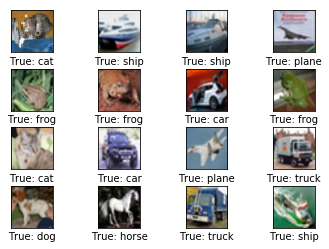

In [9]:
# Look at some test data.
visualize(testset)

Okay, now let's make some predictions with our network.

In [10]:
# Let's make some predictions on the testset.
test_iter = iter(testset)
images, labels = test_iter.next()

# Convert images to `autograd.Variable` 
# before passing through the network.
output = net(Variable(images))

The outputs are "energies" for the 10 classes. *Higher the energy for a class, the more the network thinks that the image is of the particular class*. So, let’s get the index of the highest energy:

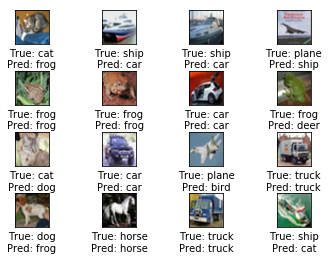

In [11]:
# torch.max returns a tuple: (value, index)
# Take the argmax of the predicted output.
_, predictions = torch.max(output.data, dim=1)

# Visualize the predictions.
imshow(images, labels=labels, pred=predictions, smooth=True)

Maybe not so bad, huh? Let's see how the result performs on the entire dataset.

In [12]:
# Keep track of correct prediction and total.
correct, total = 0, 0

# Looping through the testset.
for data in testset:
    
    # Unpack the images and labels
    # from each mini-batch.
    images, labels = data
    
    # Pass image through the network
    # to make predictions.
    outputs = net(Variable(images))
    
    # Pretrieve the index with maximum score.
    _, pred = torch.max(outputs.data, dim=1)
    
    # Get the batch size and add on to the total.
    total += labels.size(0)
    
    # Count the number of correct predictions.
    # pred == outputs means where the predictions
    # equals to the ground-truth.
    correct += (pred == labels).sum()


# Print the accuracy on the testset.
print('Accuracy on testset = {:.2%}'.format(correct/total))

Accuracy on testset = 46.46%


Well, that's slightly better than random guessing, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

In [13]:
# Each index in the `correct_class` stores
# the correct classification for that class;
# while `total_class` stores the total number
# of times we go through the class.
correct_class = torch.zeros(10)
total_class = torch.zeros(10)

# Loop through all dataset
# one batch at a time.
for data in testset:
    # Get the current batch images and labels
    images, labels = data
    
    # Pass the images through the network
    outputs = net(Variable(images))
    
    # Take the index of the maximum scores
    # returned by the network.
    _, pred = torch.max(outputs.data, dim=1)
    
    # Where the pred equals the labels will
    # return 1; and 0 otherwise.
    correct = (pred == labels).squeeze()
    
    # Loop through the batch labels
    for i, label in enumerate(labels):
        # Add on the correct predictions
        # and total for the current label.
        correct_class[label] += correct[i]
        total_class[label] += 1


# Calculate accuracy and sort in descending order
accuracy = correct_class / total_class
accuracy, _ = torch.sort(accuracy, descending=True)

for i, acc in enumerate(accuracy):
    print(f'Accuracy of {classes[i]} \t = {acc:.2%}')

Accuracy of plane 	 = 73.20%
Accuracy of car 	 = 62.40%
Accuracy of bird 	 = 61.30%
Accuracy of cat 	 = 58.40%
Accuracy of deer 	 = 49.80%
Accuracy of dog 	 = 47.10%
Accuracy of frog 	 = 35.60%
Accuracy of horse 	 = 31.50%
Accuracy of ship 	 = 23.50%
Accuracy of truck 	 = 21.80%


Okay, so what next?

How do we run these neural networks on the GPU?

### Training on GPU

Just like how you transfer a Tensor on to the GPU, you transfer the neural net onto the GPU. This will recursively go over all modules and convert their parameters and buffers to CUDA tensors:

```python
net.cuda()
```
Remember that you will have to send the inputs and targets at every step to the GPU too:

```python
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
```

Why don't I notice **MASSIVE** speedup compared to CPU? Because your network is really small.

**Exercise:** Try increasing the width of your network (argument 2 of the first `nn.Conv2d`, and argument 1 of the second `nn.Conv2d` – they need to be the same number), see what kind of speedup you get.

### Goals achieved:

- Understanding PyTorch’s Tensor library and neural networks at a high level.
- Train a small neural network to classify images

### Training on multiple GPUs

If you want to see even more MASSIVE speedup using all of your GPUs, please check out Optional: 
[Data Parallelism](../).


### Where do I go next?

- Train neural nets to play video games
- Train a state-of-the-art ResNet network on imagenet
- Train a face generator using Generative Adversarial Networks
- Train a word-level language model using Recurrent LSTM networks
- [More examples](https://github.com/pytorch/examples)
- [More tutorials](https://github.com/pytorch/tutorials)
